In [12]:
import torch
import torch.nn as nn
import torchvision
#import albumentations as A
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from torchvision.models import ResNet34_Weights
from pandas import read_csv

import numpy as np
import cv2
import os
import json
import time

from matplotlib import pyplot as plt

In [13]:
test_data = read_csv('data/test.tsv', sep='\t')
train_data = read_csv('data/train.tsv', sep='\t')

# Задание параметров обучения

In [14]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config_json = {
    "alphabet": "абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ0123456789.,;:!?~-–+=()[]{}‘/\\|+-*÷=><%^,«»„“",
    "save_dir": "data/experiment/models",
    "num_epoch": 200,
    "image": {
        "width": 64,
        "height": 32
    },
    "train": {
        "root_path": "data/train/",
        "tsv_path": "data/train.tsv",
        "batch_size": 64
    },
    "test": {
        "root_path": "data/test/",
        "tsv_path": "data/test.tsv",
        "batch_size": 128
    }
}
DEVICE

device(type='cuda')

# Вспомогательные функции

In [15]:
def strip_accuracy(s):
    return(float(s[-11:-5]))

def latest(path):
    try:
        files = os.listdir(path)
        paths = [os.path.join(path, basename) for basename in files]
        return max(paths, key=strip_accuracy)
    except FileNotFoundError:
        return None

def collate_fn(batch):
    images, texts, enc_texts = zip(*batch)
    images = torch.stack(images, 0)
    text_lens = []
    for text in texts:
        try:
            text_len = len(text)
        except TypeError:
            text_len = 6 #средняя длина слова в русском языке
        text_lens += [text_len]
    text_lens = torch.LongTensor(text_lens)
    enc_pad_texts = pad_sequence(enc_texts, batch_first=True, padding_value=0)
    return images, texts, enc_pad_texts, text_lens

def get_data_loader(
    transforms, tsv_path, root_path, tokenizer, batch_size, drop_last):
    dataset = OCRDataset(tsv_path, root_path, tokenizer, transforms)
    torch.set_num_threads(1)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        collate_fn=collate_fn,
        batch_size=batch_size,
        num_workers=0,
    )
    return data_loader


class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Определение класса датасета
Определяется как наследник класса torch.utils.data.Dataset

In [16]:
class OCRDataset(Dataset):
    def __init__(self, tsv_path, root_path, tokenizer, transform=None):
        super().__init__()
        self.transform = transform
        data = read_csv(tsv_path, sep='\t')
        self.data_len = len(data)

        self.img_paths = []
        self.texts = []
        for index, row in data.iterrows():
            img_name = row['Название']
            text = row['Текст']
            self.img_paths.append(os.path.join(root_path, img_name))
            self.texts.append(text)
        self.enc_texts = tokenizer.encode(self.texts)
        

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        text = self.texts[idx]
        enc_text = torch.LongTensor(self.enc_texts[idx])
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, text, enc_text
        lllll


# Определение токенайзера - вспомогательного класса, который преобразует текст в числа
Разметка-текст с картинок преобразуется в числовые данные, на которых производится обучение модели. Также может делать и обратное преобразование. 

In [17]:
OOV_TOKEN = '<OOV>' #"Символ" для символов вне заданного набора
CTC_BLANK = '<BLANK>' # "Символ" для пробелов

def get_char_map(alphabet):
    char_map = {value: idx + 2 for (idx, value) in enumerate(alphabet)}
    char_map[CTC_BLANK] = 0
    char_map[OOV_TOKEN] = 1
    return char_map

class Tokenizer:
    def __init__(self, alphabet):
        self.char_map = get_char_map(alphabet)
        self.rev_char_map = {val: key for key, val in self.char_map.items()}

    def encode(self, word_list):
        enc_words = []
        for word in word_list:
            enc_words.append(
                [self.char_map[char] if char in self.char_map
                 else self.char_map[OOV_TOKEN] for char in str(word)])
        return enc_words

    def get_num_chars(self):
        return len(self.char_map)

    def decode(self, enc_word_list):
        dec_words = []
        for word in enc_word_list:
            word_chars = ''
            for idx, char_enc in enumerate(word):
                if (char_enc != self.char_map[OOV_TOKEN]
                    and char_enc != self.char_map[CTC_BLANK]
                    and not (idx > 0 and char_enc == word[idx - 1])):
                    word_chars += self.rev_char_map[char_enc]
            dec_words.append(word_chars)
        return dec_words

# Задание функции метрики
В качестве метрики используется accuracy. Она измеряет долю предсказанных строк текста, которые полностью совпадают с истинным.

In [18]:
def get_accuracy(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        scores.append(true == pred)
    avg_score = np.mean(scores)
    return avg_score

# Аугментации модели
Функции для обеспечения единообразия данных для обучения.

In [19]:
class Normalize:
    def __call__(self, img):
        img = img.astype(np.float32) / 255
        return img

class ToTensor:
    def __call__(self, arr):
        arr = torch.from_numpy(arr)
        return arr

class MoveChannels:
    def __init__(self, to_channels_first=True):
        self.to_channels_first = to_channels_first

    def __call__(self, image):
        if self.to_channels_first:
            return np.moveaxis(image, -1, 0)
        else:
            return np.moveaxis(image, 0, -1)

class ImageResize:
    def __init__(self, height, width):
        self.height = height
        self.width = width

    def __call__(self, image):
        #print(image)
        image = cv2.resize(image, (self.width, self.height),
                            interpolation=cv2.INTER_LINEAR)
        return image


def get_train_transforms(height, width):
    transforms = torchvision.transforms.Compose([
        ImageResize(height, width),
        MoveChannels(to_channels_first=True),
        Normalize(),
        ToTensor()
    ])
    return transforms

def get_val_transforms(height, width):
    transforms = torchvision.transforms.Compose([
        ImageResize(height, width),
        MoveChannels(to_channels_first=True),
        Normalize(),
        ToTensor()
    ])
    return transforms

# Определение модели

In [20]:
def get_resnet34_backbone(weights=ResNet34_Weights.IMAGENET1K_V1):
    m = torchvision.models.resnet34(weights=weights)
    input_conv = nn.Conv2d(3, 64, 7, 1, 3)
    blocks = [input_conv, m.bn1, m.relu, 
              m.maxpool, m.layer1, m.layer2, m.layer3]
    return nn.Sequential(*blocks)

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out

class CRNN(nn.Module):
    def __init__(
        self, number_class_symbols, time_feature_count=256,
        lstm_hidden=256, lstm_len=2):
        super().__init__()
        self.feature_extractor = get_resnet34_backbone(weights=ResNet34_Weights.IMAGENET1K_V1)
        self.avg_pool = nn.AdaptiveAvgPool2d((time_feature_count, time_feature_count))
        self.bilstm = BiLSTM(time_feature_count, lstm_hidden, lstm_len)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden * 2, time_feature_count),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(time_feature_count, number_class_symbols))

    def forward(self, x):
        x = self.feature_extractor(x)
        b, c, h, w = x.size()
        x = x.view(b, c * h, w)
        x = self.avg_pool(x)
        x = x.transpose(1, 2)
        x = self.bilstm(x)
        x = self.classifier(x)
        x = nn.functional.log_softmax(x, dim=2).permute(1, 0, 2)
        return x

# Задание обучения

In [21]:
def val_loop(data_loader, model, tokenizer, device):
    acc_avg = AverageMeter()
    for images, texts, _, _ in data_loader:
        #print(images)
        #start = time.time()
        batch_size = len(texts)
        #print("val", batch_size, end=' ')
        text_preds = predict(images, model, tokenizer, device)
        acc_avg.update(get_accuracy(texts, text_preds), batch_size)
        #end = time.time()
        #print(end - start)
    print(f'Validation, acc: {acc_avg.avg:.4f}')
    return acc_avg.avg

def train_loop(data_loader, model, criterion, optimizer, epoch):
    start_cycle = time.time()
    loss_avg = AverageMeter()
    model.train()
    i = 0
    for images, texts, enc_pad_texts, text_lens in data_loader:
        model.zero_grad()
        images = images.to(DEVICE)
        batch_size = len(texts)
        output = model(images)
        output_lengths = torch.full(
            size=(output.size(1),),
            fill_value=output.size(0),
            dtype=torch.long)
        loss = criterion(output, enc_pad_texts, output_lengths, text_lens)
        loss_avg.update(loss.item(), batch_size)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    end_cycle = time.time()
    print(f'\nEpoch {epoch}, Loss: {loss_avg.avg:.5f}, LR: {lr:.7f}, Time elapsed: {end_cycle - start_cycle}')
    return loss_avg.avg

def predict(images, model, tokenizer, device):
    model.eval()
    images = images.to(device)
    with torch.no_grad():
        output = model(images)
    pred = torch.argmax(output.detach().cpu(), -1).permute(1, 0).numpy()
    text_preds = tokenizer.decode(pred)
    return text_preds

def get_loaders(tokenizer, config):
    train_transforms = get_train_transforms(
        height=config['image']['height'],
        width=config['image']['width'])
    train_loader = get_data_loader(
        tsv_path=config['train']['tsv_path'],
        root_path=config['train']['root_path'],
        transforms=train_transforms,
        tokenizer=tokenizer,
        batch_size=config['train']['batch_size'],
        drop_last=True)
    val_transforms = get_val_transforms(
        height=config['image']['height'],
        width=config['image']['width'])
    val_loader = get_data_loader(
        tsv_path=config['test']['tsv_path'],
        root_path=config['test']['root_path'],
        transforms=val_transforms,
        tokenizer=tokenizer,
        batch_size=config['test']['batch_size'],
        drop_last=True)
    
    return train_loader, val_loader

def train(config, checkpoint=None):
    tokenizer = Tokenizer(config['alphabet'])
    os.makedirs(config['save_dir'], exist_ok=True)
    train_loader, val_loader = get_loaders(tokenizer, config)
    
    model = CRNN(number_class_symbols=tokenizer.get_num_chars())
    model.to(DEVICE)

    if checkpoint == None:
        epoch = -1
        best_acc = -np.inf    
    else:
        if checkpoint == 'latest':
            checkpoint = latest('data\\experiment\\models\\')
        epoch = int(checkpoint[-14:-12])
        checkpoint = torch.load(checkpoint)
        model.load_state_dict(checkpoint)
        model.eval()
        best_acc = val_loop(val_loader, model, tokenizer, DEVICE)
    
    criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer, mode='max', factor=0.25, patience=10)
    
    for epoch in range(epoch + 1, config['num_epoch']):
        loss_avg = train_loop(train_loader, model, criterion, optimizer, epoch)
        acc_avg = val_loop(val_loader, model, tokenizer, DEVICE)
        scheduler.step(acc_avg)
        if acc_avg > best_acc:
            best_acc = acc_avg
            model_save_path = os.path.join(
                config['save_dir'], f'model-{epoch}-{acc_avg:.4f}.ckpt')
            torch.save(model.state_dict(), model_save_path)
            print('Model weights saved')

# Тренировка модели

In [22]:
train(config_json, 'latest') 

KeyboardInterrupt: 

# Создание предсказаний

In [23]:
class InferenceTransform:
    def __init__(self, height, width):
        self.transforms = get_val_transforms(height, width)
    def __call__(self, images):
        transformed_images = []
        for image in images:
            image = self.transforms(image)
            transformed_images.append(image)
        transformed_tensor = torch.stack(transformed_images, 0)
        return transformed_tensor

class OcrPredictor:
    def __init__(self, model_path, config, device='cuda'):
        self.tokenizer = Tokenizer(config['alphabet'])
        self.device = torch.device(device)
        # load model
        self.model = CRNN(number_class_symbols=self.tokenizer.get_num_chars())
        checkpoint = torch.load(model_path)
        self.model.load_state_dict(checkpoint)
        self.model.eval()
        self.model.to(self.device)

        self.transforms = InferenceTransform(
            height=config['image']['height'],
            width=config['image']['width'],)

    def __call__(self, images):
        if isinstance(images, (list, tuple)):
            one_image = False
        elif isinstance(images, np.ndarray):
            images = [images]
            one_image = True
        else:
            raise Exception(f"Input must contain np.ndarray, "
                            f"tuple or list, found {type(images)}.")
        images = self.transforms(images)
        pred = predict(images, self.model, self.tokenizer, self.device)

        if one_image:
            return pred[0]
        else:
            return pred

In [24]:
predictor = OcrPredictor(
    model_path=latest('data\\experiment\\models\\'),
    config=config_json
)

В качестве небольшой демонстрации работы, проверка работы модели на моем почерке.

R:\Games\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


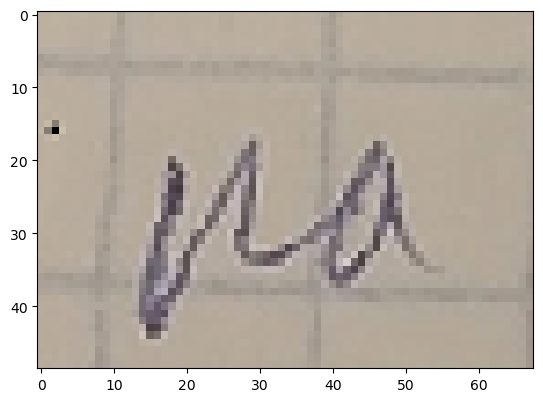

File:  110422.png
Prediction:  на


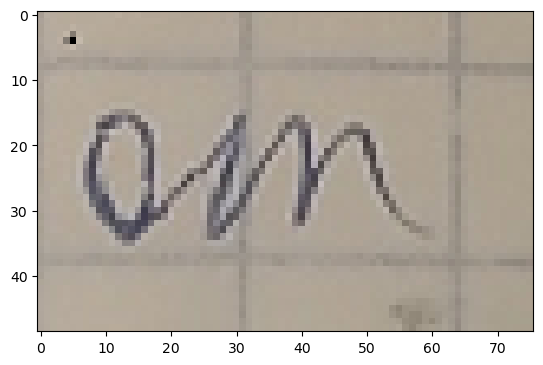

File:  110720.png
Prediction:  от


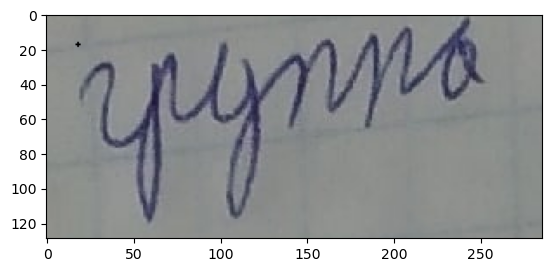

File:  110843.png
Prediction:  группы


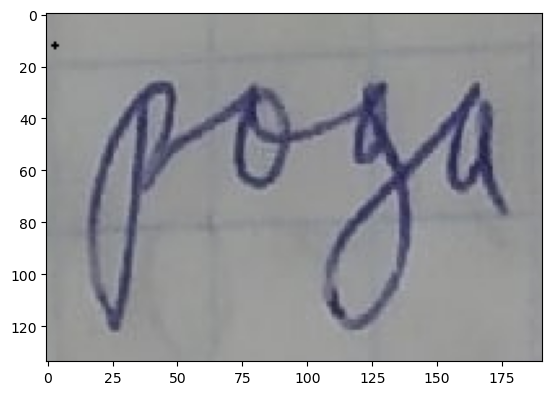

File:  110904.png
Prediction:  рода


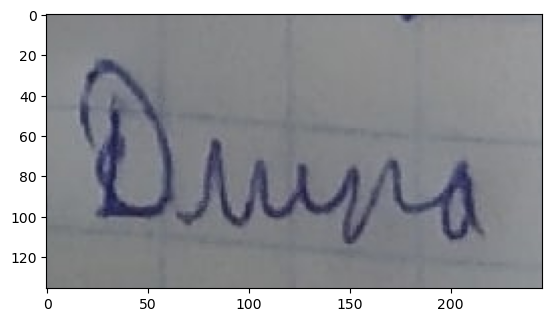

File:  110926.png
Prediction:  Длига


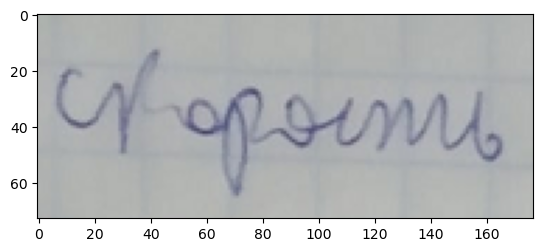

File:  112746.png
Prediction:  Игороть


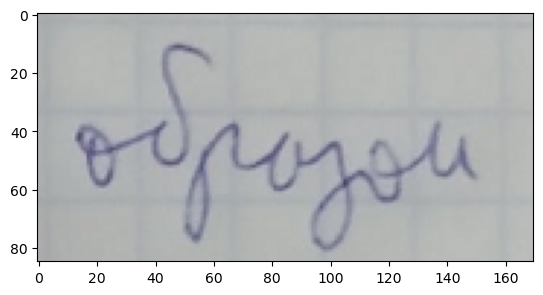

File:  112807.png
Prediction:  образм


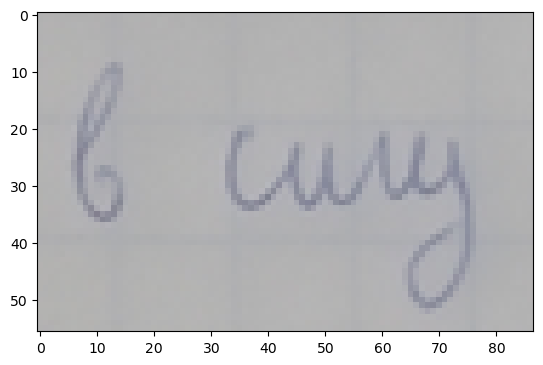

File:  112855.png
Prediction:  всиу


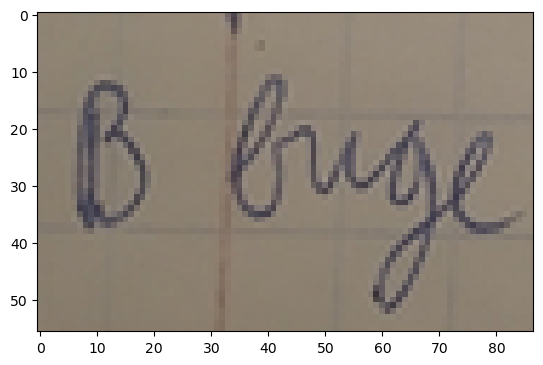

File:  112929.png
Prediction:  Ввизе


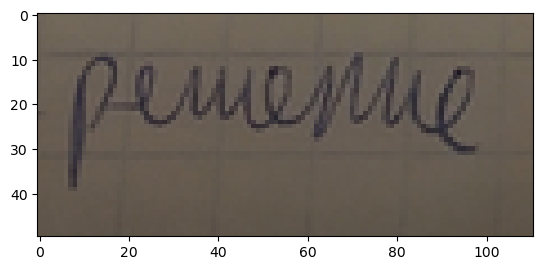

File:  113226.png
Prediction:  решение


In [25]:
#pred_json = {}

count = 0
print_images = True
dir_path = 'data/experiment/test'
for img_name in os.listdir(dir_path):
    img = cv2.imread(f'{dir_path}/{img_name}')

    pred = predictor(img)
    #pred_json[img_name] = pred

    if print_images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.show()
        print('File: ', img_name)
        print('Prediction: ', predictor(img))
        count += 1

    if count > 10:
        break
        print_images = False